In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bioresponse/svm_benchmark.csv
/kaggle/input/bioresponse/train.csv
/kaggle/input/bioresponse/test.csv


In [2]:
import pandas as pd
import numpy as np 

import sklearn
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn import pipeline
import lightgbm as lgb

## for visualization
import plotly.express as px
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [3]:
df_train = pd.read_csv("../input/bioresponse/train.csv")
df_test = pd.read_csv("../input/bioresponse/test.csv")
benchmark= pd.read_csv("../input/bioresponse/svm_benchmark.csv")

In [4]:
Y = df_train.Activity
X = df_train.drop('Activity', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(df_test)




In [5]:
pca_1776 = PCA(n_components=1776)
pca_1776.fit(X_scaled)
X_scaled_1776 = pca_1776.transform(X_scaled)
print('variance ratio :', pca_1776.explained_variance_ratio_*100)

variance ratio : [1.08386286e+01 6.16454225e+00 4.00120797e+00 ... 6.29628914e-32
 6.29628914e-32 6.29628914e-32]


Text(0, 0.5, 'Explained Variance')

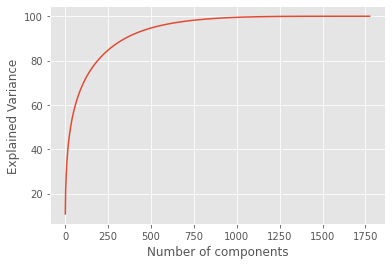

In [6]:
np.cumsum(pca_1776.explained_variance_ratio_*100)[515] ### 515 features captures 95% of the variability in the data
plt.plot(np.cumsum(pca_1776.explained_variance_ratio_*100))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")

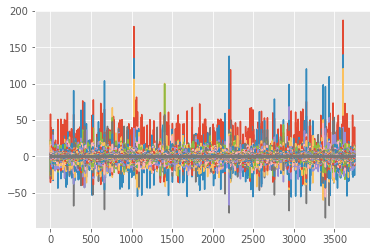

In [7]:
pca_515 = PCA(n_components=515)
pca_515.fit(X_scaled)
X_scaled_515 = pca_515.transform(X_scaled)
X_test_scaled_515 = pca_515.transform(X_test_scaled)
plt.plot(X_scaled_515);

In [8]:
new_df = pd.DataFrame(X_scaled_515, columns=[('PCA'+'{}').format(i) for i in range(1,516)] )
new_df.shape

(3751, 515)

In [9]:
X_train,X_valid, y_train,y_valid = train_test_split(new_df,Y,test_size=0.25, random_state=42)
rf = RandomForestClassifier(n_estimators=500, max_depth=25, min_samples_split=5)
rf.fit(X_train,y_train)
print(accuracy_score(rf.predict(X_valid), y_valid))

0.7750533049040512


In [10]:
rf2 = RandomForestClassifier(n_estimators=500, max_depth=25, min_samples_split=5)
rf2.fit(new_df,Y)
pred = rf2.predict_proba(X_test_scaled_515)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [11]:

submission = pd.DataFrame({'MoleculeId': range(1,df_test.shape[0]+1),
                        'PredictedProbability': pred[:,1]})
submission.to_csv('submission.csv', index=False)

In [12]:
submission

,MoleculeId,PredictedProbability
0,1,0.598302
1,2,0.595532
2,3,0.672033
3,4,0.865886
4,5,0.309450
...,...,...
2496,2497,0.388584
2497,2498,0.388114
2498,2499,0.843248
2499,2500,0.695149
